In [3]:
import os
import sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import dgl
import torch

# 현재 파일의 상위 디렉토리를 sys.path에 추가
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

c:\Programming\Anaconda\envs\chem\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# 재현성 난수 고정
def SET_SEED():
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    dgl.random.seed(SEED)

    os.environ['PYTHONHASHSEED'] = str(SEED)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 100
SET_SEED()

In [5]:
dataset = 'logvp' # freesolv / esol / lipo / logp / logvp
save_dir = r'..\results_figure'

In [6]:
df = pd.read_csv(r'..\datasets\\' + dataset + '.csv')
smiles_list = df['smiles'].tolist()

# target 정의
target = df.iloc[:,-1]

print(smiles_list[:5])
print(target[:5])

['C=O', 'CNN', 'C(=O)O', 'CCl', 'CN']
0    8.266164
1    3.912023
2    3.751854
3    8.366370
4    7.882315
Name: logvp, dtype: float64


In [7]:
from utils.utils import MolecularFeatureExtractor
# 분자 특성 추출 및 데이터프레임 정의
extractor = MolecularFeatureExtractor()
df_all_features = extractor.extract_molecular_features(smiles_list)

df_all_features['target'] = target
df_all_features

num_all_features = df_all_features.shape[1] - 1 
# na handling
# NA 확인
df_all_features[df_all_features.isna().any(axis = 1)] # 행방향


df_removed_features = df_all_features.dropna()

# 결측치가 포함된 feature 제거
# df_removed_features = df_all_features.dropna(axis = 1)
num_removed_features = df_removed_features.shape[1] - 1  # logvp 열 제외



# nunique == 1 인 경우는 제
unique_columns = list(df_removed_features.loc[:, df_removed_features.nunique() == 1].columns)
# nunique == 1인 feature 제거
#df_removed_features.drop(columns = unique_columns, inplace = True)
df_removed_features = df_removed_features.drop(columns = unique_columns).copy()

num_removed_features = df_removed_features.shape[1] - 1  # logvp 열 제외


# 너무 낮은 vairnace를 가지는 경
low_variances = sorted(df_removed_features.var())
low_variances[:10]

columns_low_variances = []

for i in low_variances:
    if i < 0.001:
        column = df_removed_features.loc[:, df_removed_features.var() == i].columns
        columns_low_variances.append(column)
columns_low_variances = [item for index in columns_low_variances for item in index]

# 2. 중복 제거 및 유니크 값 추출
columns_low_variances = list(set(columns_low_variances))

# 낮은 분산의 변수 제거
df_removed_features = df_removed_features.drop(columns = columns_low_variances).reset_index(drop=True).copy()
num_removed_features = df_removed_features.shape[1] - 1  # logvp 열 제외

[16:29:16] SMILES Parse Error: syntax error while parsing: FH
[16:29:16] SMILES Parse Error: Failed parsing SMILES 'FH' for input: 'FH'
[16:29:16] Explicit valence for atom # 1 Br, 5, is greater than permitted


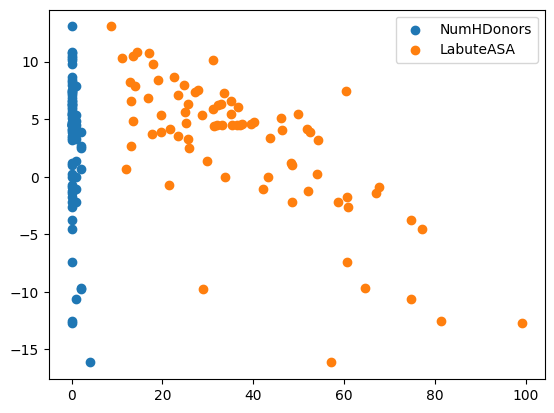

In [8]:
import matplotlib.pyplot as plt

plt.scatter(x = df_removed_features['NumHDonors'], y = df_removed_features['target'])
plt.scatter(x = df_removed_features['LabuteASA'], y = df_removed_features['target'])
plt.legend(['NumHDonors', 'LabuteASA'] ,loc='best')
plt.show()


In [ ]:
# # logP

# plt.scatter(x = df_removed_features['MolLogP'], y = df_removed_features['target'])
# plt.scatter(x = df_removed_features['VSA_EState1'], y = df_removed_features['target'])
# plt.scatter(x = df_removed_features['PEOE_VSA2'], y = df_removed_features['target'])
# plt.legend(['MolLogP', 'VSA_EState1', 'PEOE_VSA2'],loc='best')
# plt.show()